Anatomy of ASDF Internals and How the Python Library Works with them
================================================================

High Level Structure
--------------------------

The high level structure of an ASDF file is fairly simple. It starts with a few lines indicating that it is an ASDF file, what version of ASDF created it and the version of YAML that was used. This is followed by a header in YAML format, which is intended to define all metadata and references to all binary data. Binary data, if there is any, follows the YAML in binary blocks. Generally speaking, simple arrays and tables each use a binary block (views into such arrays and tables are supported). Currently there is a block index at the end of the file to enable quicker access to individual blocks.

The following schematically illustrates this structure where there are two arrays stored in two binary blocks.

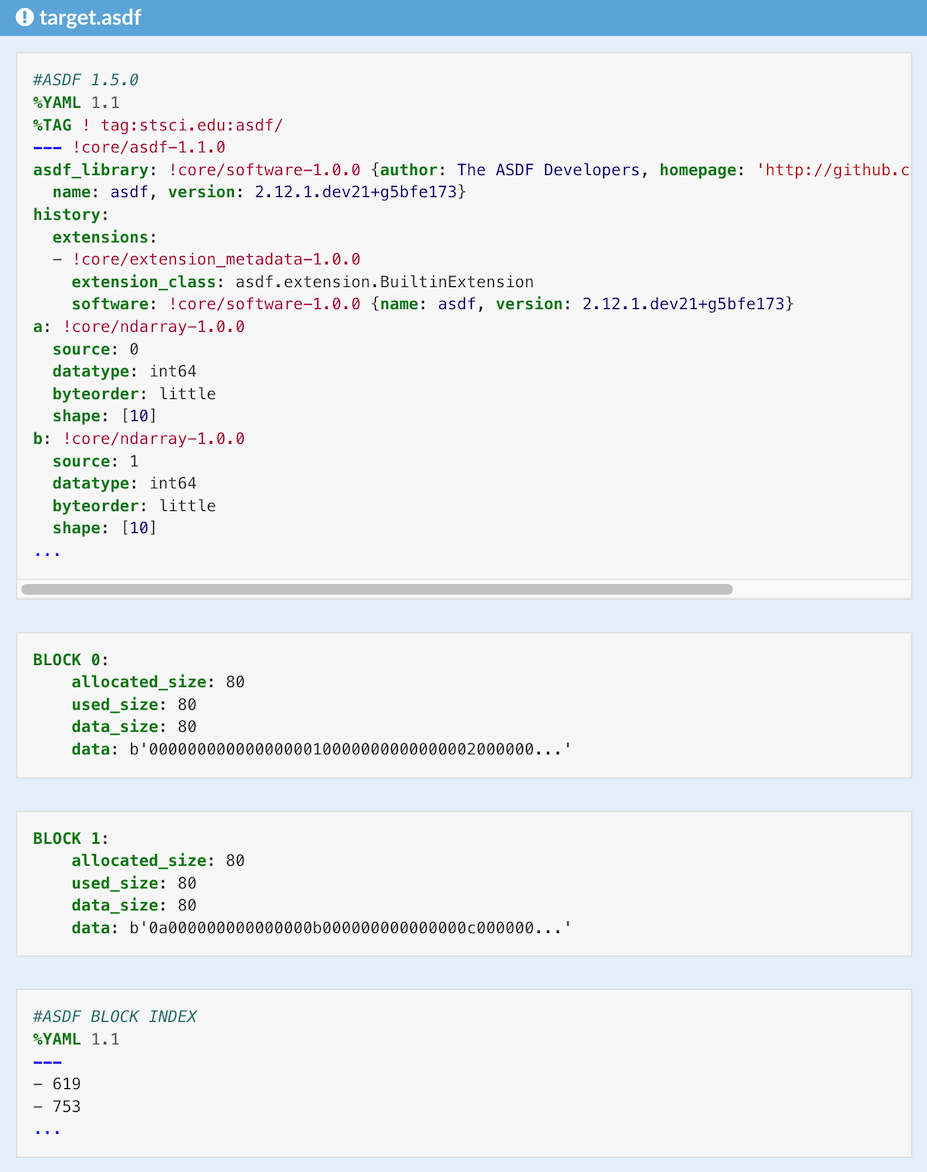

When the asdf library opens a file such as this, the arrays are not loaded until the attribute is "accessed". For example:

In [1]:
import asdf
af = asdf.open('demo.asdf')
tree = af.tree # no arrays have been loaded
a = tree['a'] # Array still isn't loaded
print(a)
a[2] # This loads the array
print(a)

<array (unloaded) shape: [10] dtype: int64>
[0 1 2 3 4 5 6 7 8 9]


**Primitive Content**

Untagged elements get turned into Python dicts, lists, and basic data types (strings, floats, ints, and booleans) corresponding the YAML structure.

In [2]:
tree = {'a': 6.0, 'b': True, 'c': 11, 'd':'goodbye world', 'e': [1, 4, 9, 16],
        'f':{'x': [1, 3, 5], 'y':{'nests': True, 'top': False}}}
af = asdf.AsdfFile(tree)
af.write_to('primitive.asdf')
text = open('primitive.asdf').read()
print(text)

#ASDF 1.0.0
#ASDF_STANDARD 1.5.0
%YAML 1.1
%TAG ! tag:stsci.edu:asdf/
--- !core/asdf-1.1.0
asdf_library: !core/software-1.0.0 {author: The ASDF Developers, homepage: 'http://github.com/asdf-format/asdf',
  name: asdf, version: 2.11.2.dev15+g6703d8f.d20220607}
history:
  extensions:
  - !core/extension_metadata-1.0.0
    extension_class: asdf.extension.BuiltinExtension
    software: !core/software-1.0.0 {name: asdf, version: 2.11.2.dev15+g6703d8f.d20220607}
a: 6.0
b: true
c: 11
d: goodbye world
e: [1, 4, 9, 16]
f:
  x: [1, 3, 5]
  y: {nests: true, top: false}
...



In [3]:
af2 = asdf.open('primitive.asdf')
tree = af2.tree
tree

{'asdf_library': {'author': 'The ASDF Developers',
  'homepage': 'http://github.com/asdf-format/asdf',
  'name': 'asdf',
  'version': '2.11.2.dev15+g6703d8f.d20220607'},
 'history': {'extensions': [{'extension_class': 'asdf.extension.BuiltinExtension',
    'software': {'name': 'asdf',
     'version': '2.11.2.dev15+g6703d8f.d20220607'}}]},
 'a': 6.0,
 'b': True,
 'c': 11,
 'd': 'goodbye world',
 'e': [1, 4, 9, 16],
 'f': {'x': [1, 3, 5], 'y': {'nests': True, 'top': False}}}

**Tags**

The use of YAML tag syntax is used as a mechanism by the Python library to do something special with the content that follows.

The asdf library has machinery that links tags to code that knows how to turn the content into a Python object, as well as find an associated schema to validate that content in the ASDF file (examples covered in the next segment).

You have already seen one example of a tag, that is, for array data. Anyone can define their own tags and write their own converters for turning tags into Python objects.

In serializing these objects to ASDF, the converters also register Python types that they handle, and the tags that are associated with the type. When that type is serialized, it will be labeled with a tag so that when reading it back in, it will generate an identical object (but not the same object!).

We will use an example that uses tags defined in the astropy library that handle quantities. Quantities are floats (scalars or arrays) that have associated units.

In [4]:
import astropy.units as u
import numpy as np
q1 = 1609.34 * u.m
q2 = np.arange(10) * (u.imperial.mile / u.hour)
print(q1)
print(q2)

1609.34 m
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] mi / h


In [5]:
tree = {'distance': q1, 'speed': q2}
af.tree = tree
af.write_to('tagdemo.asdf', all_array_storage='inline')
text = open('tagdemo.asdf').read()
print(text)

#ASDF 1.0.0
#ASDF_STANDARD 1.5.0
%YAML 1.1
%TAG ! tag:stsci.edu:asdf/
--- !core/asdf-1.1.0
asdf_library: !core/software-1.0.0 {author: The ASDF Developers, homepage: 'http://github.com/asdf-format/asdf',
  name: asdf, version: 2.11.2.dev15+g6703d8f.d20220607}
history:
  extensions:
  - !core/extension_metadata-1.0.0
    extension_class: asdf.extension.BuiltinExtension
    software: !core/software-1.0.0 {name: asdf, version: 2.11.2.dev15+g6703d8f.d20220607}
  - !core/extension_metadata-1.0.0
    extension_class: asdf.extension._manifest.ManifestExtension
    extension_uri: asdf://asdf-format.org/core/extensions/core-1.5.0
    software: !core/software-1.0.0 {name: asdf-astropy, version: 0.2.1}
distance: !unit/quantity-1.1.0 {unit: !unit/unit-1.0.0 m, value: 1609.34}
speed: !unit/quantity-1.1.0
  unit: !unit/unit-1.0.0 160934.4cm.h**-1
  value: !core/ndarray-1.0.0
    data: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
    datatype: float64
    shape: [10]
...



In [6]:
af2 = asdf.open('tagdemo.asdf')
tree2 = af2.tree
print(type(tree2['distance']))
print(tree2['distance'])
print(type(tree2['speed']))
print(tree2['speed'])

<class 'astropy.units.quantity.Quantity'>
1609.34 m
<class 'astropy.units.quantity.Quantity'>
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 160934 cm / h


In [7]:
tree2['distance'] * (1 / (3600 * u.s))

<Quantity 0.44703889 m / s>

**Avoiding copies in ASDF files**

In hierarchical structures, it may be necesary for different components to refer to the same object. Ideally one does not want to have multiple copies in such a case. YAML provides a mechanism to avoid that. The Python library recognizes when this is the case and serializes the information only one time. The following illustrates this in a case where two data arrays share the same masking array.

In [8]:
import numpy.random as nr
rng = nr.default_rng()
mask = rng.integers(2, size=10)
data1 = rng.random(size=10)
data2 = rng.random(size=10)
af.tree = {'dataset1': {'data': data1, 'mask': mask}, 'dataset2': {'data': data2, 'mask': mask}}
af.write_to('refdemo.asdf', all_array_storage='inline')
text = open('refdemo.asdf').read()
print(text)

#ASDF 1.0.0
#ASDF_STANDARD 1.5.0
%YAML 1.1
%TAG ! tag:stsci.edu:asdf/
--- !core/asdf-1.1.0
asdf_library: !core/software-1.0.0 {author: The ASDF Developers, homepage: 'http://github.com/asdf-format/asdf',
  name: asdf, version: 2.11.2.dev15+g6703d8f.d20220607}
history:
  extensions:
  - !core/extension_metadata-1.0.0
    extension_class: asdf.extension.BuiltinExtension
    software: !core/software-1.0.0 {name: asdf, version: 2.11.2.dev15+g6703d8f.d20220607}
dataset1:
  data: !core/ndarray-1.0.0
    data: [0.5538222843361178, 0.8338040666226186, 0.5032400682019836, 0.6489859630487227,
      0.940507655931943, 0.4338576793859923, 0.6307560000330947, 0.7661341108601463,
      0.5102926295798412, 0.06303398898152357]
    datatype: float64
    shape: [10]
  mask: &id001 !core/ndarray-1.0.0
    data: [1, 0, 0, 0, 1, 1, 0, 1, 1, 0]
    datatype: int64
    shape: [10]
dataset2:
  data: !core/ndarray-1.0.0
    data: [0.9748765313028576, 0.03634182673295683, 0.6233977185883307, 0.6835299146421616

In [9]:
af2 = asdf.open('refdemo.asdf')
t = af2.tree
print(id(t['dataset1']['mask']))
print(id(t['dataset2']['mask']))
print(t['dataset1']['mask'])

140598200014256
140598200014256
[1 0 0 0 1 1 0 1 1 0]


Exercises
----------------


1. To illustrate that ASDF files without binary data can be edited by hand, modify a copy of the tagdemo.asdf file with a text editor to double the size of the speed array, and and add another scalar quantity (your choice of attribute name and units; for documentation on astropy units available see: https://docs.astropy.org/en/stable/units/index.html#module-astropy.units.si ). Note that you will need to include the appropriate tags for the new quantity using the other instances as a template.

2. Open with asdf the file ../data/04-exercise2.asdf and use info to find shared items, and all special objects in the file (e.g., anything that is not a dict, list, or primitive value). List these along with their types.

3. Define a common multi-line description for all the dicts that have "widget" in their attribute name and add it as the "description" attribute for that dict. Save the file and confirm by editor, less, or any other tool to view the contents that this description only appears once in the YAML, and is referred to in all other references to it.